<a href="https://colab.research.google.com/github/Mallikarjunreddy3015/3DCNN/blob/main/3DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import tensorflow as tf
import datetime as dt
import h5py
import tensorflow as tf
import numpy as np
import h5py
import tensorflow as tf
import numpy as np
import tensorflow as tf
import numpy as np

import tensorflow as tf
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import numpy as np
import h5py
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#  Copyright (C) 2012 Daniel Maturana
#  This file is part of binvox-rw-py.
#
#  binvox-rw-py is free software: you can redistribute it and/or modify
#  it under the terms of the GNU General Public License as published by
#  the Free Software Foundation, either version 3 of the License, or
#  (at your option) any later version.
#
#  binvox-rw-py is distributed in the hope that it will be useful,
#  but WITHOUT ANY WARRANTY; without even the implied warranty of
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#  GNU General Public License for more details.
#
#  You should have received a copy of the GNU General Public License
#  along with binvox-rw-py. If not, see <http://www.gnu.org/licenses/>.
#

"""
Binvox to Numpy and back.
>>> import numpy as np
>>> with open('chair.binvox', 'rb') as f:
...     m1 = read_as_3d_array(f)
...
>>> m1.dims
[32, 32, 32]
>>> m1.scale
41.133000000000003
>>> m1.translate
[0.0, 0.0, 0.0]
>>> with open('chair_out.binvox', 'wb') as f:
...     m1.write(f)
...
>>> with open('chair_out.binvox', 'rb') as f:
...     m2 = read_as_3d_array(f)
...
>>> m1.dims==m2.dims
True
>>> m1.scale==m2.scale
True
>>> m1.translate==m2.translate
True
>>> np.all(m1.data==m2.data)
True
>>> with open('chair.binvox', 'rb') as f:
...     md = read_as_3d_array(f)
...
>>> with open('chair.binvox', 'rb') as f:
...     ms = read_as_coord_array(f)
...
>>> data_ds = .dense_to_sparse(md.data)
>>> data_sd = sparse_to_dense(ms.data, 32)
>>> np.all(data_sd==md.data)
True
>>> # the ordering of elements returned by numpy.nonzero changes with axis
>>> # ordering, so to compare for equality we first lexically sort the voxels.
>>> np.all(ms.data[:, np.lexsort(ms.data)] == data_ds[:, np.lexsort(data_ds)])
True
"""

import numpy as np


class Voxels(object):
    """ Holds a binvox model.
    data is either a three-dimensional numpy boolean array (dense representation)
    or a two-dimensional numpy float array (coordinate representation).
    dims, translate and scale are the model metadata.
    dims are the voxel dimensions, e.g. [32, 32, 32] for a 32x32x32 model.
    scale and translate relate the voxels to the original model coordinates.
    To translate voxel coordinates i, j, k to original coordinates x, y, z:
    x_n = (i+.5)/dims[0]
    y_n = (j+.5)/dims[1]
    z_n = (k+.5)/dims[2]
    x = scale*x_n + translate[0]
    y = scale*y_n + translate[1]
    z = scale*z_n + translate[2]
    """

    def __init__(self, data, dims, translate, scale, axis_order):
        self.data = data
        self.dims = dims
        self.translate = translate
        self.scale = scale
        assert (axis_order in ('xzy', 'xyz'))
        self.axis_order = axis_order

    def clone(self):
        data = self.data.copy()
        dims = self.dims[:]
        translate = self.translate[:]
        return Voxels(data, dims, translate, self.scale, self.axis_order)

    def write(self, fp):
        write(self, fp)


def read_header(fp):
    """ Read binvox header. Mostly meant for internal use.
    """
    line = fp.readline().strip()
    if not line.startswith(b'#binvox'):
        raise IOError('Not a binvox file')
    dims = list(map(int, fp.readline().strip().split(b' ')[1:]))
    translate = list(map(float, fp.readline().strip().split(b' ')[1:]))
    scale = list(map(float, fp.readline().strip().split(b' ')[1:]))[0]
    line = fp.readline()
    return dims, translate, scale


def read_as_3d_array(fp, fix_coords=True):
    """ Read binary binvox format as array.
    Returns the model with accompanying metadata.
    Voxels are stored in a three-dimensional numpy array, which is simple and
    direct, but may use a lot of memory for large models. (Storage requirements
    are 8*(d^3) bytes, where d is the dimensions of the binvox model. Numpy
    boolean arrays use a byte per element).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)
    # if just using reshape() on the raw data:
    # indexing the array as array[i,j,k], the indices map into the
    # coords as:
    # i -> x
    # j -> z
    # k -> y
    # if fix_coords is true, then data is rearranged so that
    # mapping is
    # i -> x
    # j -> y
    # k -> z
    values, counts = raw_data[::2], raw_data[1::2]
    data = np.repeat(values, counts).astype(bool)
    data = data.reshape(dims)
    if fix_coords:
        # xzy to xyz TODO the right thing
        data = np.transpose(data, (0, 2, 1))
        axis_order = 'xyz'
    else:
        axis_order = 'xzy'
    return Voxels(data, dims, translate, scale, axis_order)


def read_as_coord_array(fp, fix_coords=True):
    """ Read binary binvox format as coordinates.
    Returns binvox model with voxels in a "coordinate" representation, i.e.  an
    3 x N array where N is the number of nonzero voxels. Each column
    corresponds to a nonzero voxel and the 3 rows are the (x, z, y) coordinates
    of the voxel.  (The odd ordering is due to the way binvox format lays out
    data).  Note that coordinates refer to the binvox voxels, without any
    scaling or translation.
    Use this to save memory if your model is very sparse (mostly empty).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)

    values, counts = raw_data[::2], raw_data[1::2]

    sz = np.prod(dims)
    index, end_index = 0, 0
    end_indices = np.cumsum(counts)
    indices = np.concatenate(([0], end_indices[:-1])).astype(end_indices.dtype)

    values = values.astype(bool)
    indices = indices[values]
    end_indices = end_indices[values]

    nz_voxels = []
    for index, end_index in zip(indices, end_indices):
        nz_voxels.extend(range(index, end_index))
    nz_voxels = np.array(nz_voxels)
    # TODO are these dims correct?
    # according to docs,
    # index = x * wxh + z * width + y; // wxh = width * height = d * d

    x = nz_voxels / (dims[0]*dims[1])
    zwpy = nz_voxels % (dims[0]*dims[1])  # z*w + y
    z = zwpy / dims[0]
    y = zwpy % dims[0]
    if fix_coords:
        data = np.vstack((x, y, z))
        axis_order = 'xyz'
    else:
        data = np.vstack((x, z, y))
        axis_order = 'xzy'

    # return Voxels(data, dims, translate, scale, axis_order)
    return Voxels(np.ascontiguousarray(data), dims, translate, scale, axis_order)


def dense_to_sparse(voxel_data, dtype=int):
    """ From dense representation to sparse (coordinate) representation.
    No coordinate reordering.
    """
    if voxel_data.ndim != 3:
        raise ValueError('voxel_data is wrong shape; should be 3D array.')
    return np.asarray(np.nonzero(voxel_data), dtype)


def sparse_to_dense(voxel_data, dims, dtype=bool):
    if voxel_data.ndim != 2 or voxel_data.shape[0] != 3:
        raise ValueError('voxel_data is wrong shape; should be 3xN array.')
    if np.isscalar(dims):
        dims = [dims]*3
    dims = np.array(dims, dtype=int).reshape(-1, 1)

    # truncate to integers
    xyz = voxel_data.astype(int)
    # discard voxels that fall outside dims
    valid_ix = ~np.any((xyz < 0) | (xyz >= dims), 0)
    xyz = xyz[:, valid_ix]
    out = np.zeros(dims.flatten(), dtype=dtype)
    out[tuple(xyz)] = True
    return out


# def get_linear_index(x, y, z, dims):
    # """ Assuming xzy order. (y increasing fastest.
    # TODO ensure this is right when dims are not all same
    # """
    # return x*(dims[1]*dims[2]) + z*dims[1] + y


def write(voxel_model, fp):
    """ Write binary binvox format.
    Note that when saving a model in sparse (coordinate) format, it is first
    converted to dense format.
    Doesn't check if the model is 'sane'.
    """
    if voxel_model.data.ndim == 2:
        # TODO avoid conversion to dense
        dense_voxel_data = sparse_to_dense(voxel_model.data, voxel_model.dims)
    else:
        dense_voxel_data = voxel_model.data

    fp.write('#binvox 1\n')
    fp.write('dim '+' '.join(map(str, voxel_model.dims))+'\n')
    fp.write('translate '+' '.join(map(str, voxel_model.translate))+'\n')
    fp.write('scale '+str(voxel_model.scale)+'\n')
    fp.write('data\n')
    if not voxel_model.axis_order in ('xzy', 'xyz'):
        raise ValueError('Unsupported voxel model axis order')

    if voxel_model.axis_order == 'xzy':
        voxels_flat = dense_voxel_data.flatten()
    else:
        voxels_flat = np.transpose(dense_voxel_data, (0, 2, 1)).flatten()

    # keep a sort of state machine for writing run length encoding
    state = voxels_flat[0]
    ctr = 0
    for c in voxels_flat:
        if c == state:
            ctr += 1
            # if ctr hits max, dump
            if ctr == 255:
                fp.write(chr(state))
                fp.write(chr(ctr))
                ctr = 0
        else:
            # if switch state, dump
            fp.write(chr(state))
            fp.write(chr(ctr))
            state = c
            ctr = 1
    # flush out remainders
    if ctr > 0:
        fp.write(chr(state))
        fp.write(chr(ctr))

In [ ]:
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go



def read_h5(split):
    hf = h5py.File(split + ".h5", 'r')
    labels = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0,
              16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}

    for key in list(hf.keys()):
        with h5py.File('filename.h5', 'r') as f:
    # # Load the 'x' and 'y' datasets from the file
         x = np.array(f['group/x'], dtype=np.float32)
         y = np.array(f['group/y'], dtype=np.int8)

        print(f"Group: {f}")
        print(f"X: {np.shape(x)}")
        print(f"Y: {y}")

        for label in y:
            labels[label] += 1

    hf.close()

    print(labels)


def split_dataset(split, samples):
    random.shuffle(samples)
    random.shuffle(samples)

    train_idx = int(math.ceil(split["train"] * len(samples)))
    val_idx = int(math.ceil((split["val"] * len(samples))) + train_idx)

    train_list = samples[:train_idx]
    val_list = samples[train_idx:val_idx]
    test_list = samples[val_idx:]

    return train_list, val_list, test_list


def read_voxel_from_binvox(filepath, normalize=True):
    with open(filepath, "rb") as f:
        model = read_as_3d_array(f)
    voxel = model.data

    if normalize:
        voxel = zero_centering_norm(voxel)

    filename = filepath.split("\\")[-1]
    label = filename.split("_")[0]
    if  label.isdigit():
     voxel = np.array(voxel, dtype=np.float32)
     label = np.array(label, dtype=np.int8)

    return voxel, label


def zero_centering_norm(voxels):
    norm = (voxels - 0.5) * 2
    return norm


def display_voxel(voxels):
    fig = go.Figure(data=go.Volume(
        x=voxels[:, :, :, 0],
        y=voxels[:, :, :, 1],
        z=voxels[:, :, :, 2],
        value=voxels[:, :, :, 3],
        isomin=0,
        isomax=1,
        opacity=0.1,
        surface_count=21,
        ))
    fig.show()


In [ ]:

class FeatureNet(tf.keras.Model):

    def __init__(self, num_classes):
        super(FeatureNet, self).__init__()

        self.conv_1 = tf.keras.layers.Conv3D(filters=32, kernel_size=7, strides=(2, 2, 2), padding="same", use_bias=True,
                                             name="conv_1")
        self.conv_2 = tf.keras.layers.Conv3D(filters=32, kernel_size=5, strides=(1, 1, 1), padding="same", use_bias=True,
                                              name="conv_2")
        self.conv_3 = tf.keras.layers.Conv3D(filters=64, kernel_size=4, strides=(1, 1, 1), padding="same", use_bias=True,
                                              name="conv_3")
        self.conv_4 = tf.keras.layers.Conv3D(filters=64, kernel_size=3, strides=(1, 1, 1), padding="same", use_bias=True,
                                             name="conv_4")

        self.bn_1 = tf.keras.layers.BatchNormalization(name="batch_norm_1")

        self.pooling_1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding="same",
                                                   name="pooling_1")

        self.flatten = tf.keras.layers.Flatten()
        self.fc_1 = tf.keras.layers.Dense(units=128, use_bias=True, name="fc_1")
        self.fc_2 = tf.keras.layers.Dense(units=num_classes, use_bias=True, name="fc_2")
        self.softmax = tf.keras.layers.Softmax()

    def call(self, input, training=False):

        x = self.conv_1(input)
        x = self.bn_1(x)
        x = tf.nn.relu(x)

        x = self.conv_2(x)
        x = tf.nn.relu(x)

        x = self.conv_3(x)
        x = tf.nn.relu(x)

        x = self.conv_4(x)
        x = tf.nn.relu(x)

        x = self.pooling_1(x)
        x = self.flatten(x)

        x = self.fc_1(x)
        x = tf.nn.relu(x)
        x = self.fc_2(x)
        x = self.softmax(x)

        return x


In [ ]:



# def dataloader_h5(file_path):
#     hf = h5py.File(file_path, 'r')

#     for key in list(hf.keys()):
#         group = hf.get(key)
#         x = tf.convert_to_tensor(np.array(group.get("x"), dtype=np.float32))
#         x = tf.Variable(x, dtype=tf.float32, name="x")
 
#         y = np.array(group["y"], dtype=np.int8)

#         yield x, y

#     hf.close()
def dataloader_h5(file_path):
    hf = h5py.File(file_path, 'r')

    for key in hf.keys():
        group = hf.get(key)
        if group is not None and isinstance(group, h5py.Group):
            x = tf.convert_to_tensor(np.array(group["x"], dtype=np.float32))
            x = tf.Variable(x, dtype=tf.float32, name="x")
            y = np.array(group["y"], dtype=np.int8)
            yield x, y

    hf.close()


def read_voxel_from_binvox(filepath, normalize=True):
    with open(filepath, "rb") as f:
        model = read_as_3d_array(f)
    voxel = model.data

    if normalize:
        voxel = zero_centering_norm(voxel)

    filename = filepath.split("/")[-1]
    voxel = tf.convert_to_tensor(np.array(voxel, dtype=np.float32))
    voxel = tf.Variable(voxel, dtype=tf.float32, name="x")


    return voxel

# New Section

In [ ]:


def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_variables)

    grads = [tf.clip_by_norm(g, 1.0) for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss_metric.update_state(loss_value)
    train_acc_metric.update_state(y, logits)


def val_step(x, y):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)

    val_loss_metric.update_state(loss_value)
    val_acc_metric.update_state(y, val_logits)


if 1 == 1:
    # User Parameters
    num_classes = 24
    num_epochs = 30
    learning_rate = 0.001
    training_set_path = "/content/drive/MyDrive/3DCNN/train.h5"
    val_set_path = "/content/drive/MyDrive/3DCNN/val.h5"

    decay_rate = learning_rate / num_epochs
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
                                                                 decay_steps=100000, decay_rate=decay_rate)

    save_name = f'featurenet_date_{dt.datetime.now().strftime("%Y-%m-%d")}'

    model = FeatureNet(num_classes=num_classes)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    summary_writer = tf.summary.create_file_writer(f'./log/{save_name}')

    train_loss_metric = tf.keras.metrics.Mean()
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_loss_metric = tf.keras.metrics.Mean()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    min_val_loss = 0.0
    min_train_loss = 0.0
    max_train_acc = 0.0
    max_val_acc = 0.0
    max_epoch = 0

    for epoch in tf.range(num_epochs):
        print(f"Epoch {epoch + 1} of {num_epochs}")
        start_time = time.time()

        train_dataloader = dataloader_h5(training_set_path)
        val_dataloader = dataloader_h5(val_set_path)

        with summary_writer.as_default():
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataloader):
                one_hot_y = tf.one_hot(y_batch_train, depth=num_classes)
                train_step(x_batch_train, one_hot_y)

                # Log every 20 batches.
                if step % 100 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(train_loss_metric.result()))
                    )

            train_loss = train_loss_metric.result()
            train_acc = train_acc_metric.result()

            tf.summary.scalar('train_loss', train_loss, step=optimizer.iterations)
            tf.summary.scalar('train_acc', train_acc, step=optimizer.iterations)

            train_loss_metric.reset_states()
            train_acc_metric.reset_states()

            print(f"Train loss={train_loss}, Train acc={train_acc}")

            for x_batch_val, y_batch_val in val_dataloader:
                one_hot_y = tf.one_hot(y_batch_val, depth=num_classes)
                val_step(x_batch_val, one_hot_y)

            val_loss = val_loss_metric.result()
            val_acc = val_acc_metric.result()

            if val_acc > max_val_acc:
                min_val_loss = float(val_loss)
                min_train_loss = float(train_loss)
                max_train_acc = float(train_acc)
                max_val_acc = float(val_acc)
                model.save_weights(f"checkpoint/{save_name}.ckpt")
                max_epoch = epoch

            tf.summary.scalar('val_loss', val_loss, step=optimizer.iterations)
            tf.summary.scalar('val_acc', val_acc, step=optimizer.iterations)

            val_loss_metric.reset_states()
            val_acc_metric.reset_states()

            print(f"Val loss={val_loss}, Val acc={val_acc}")
            print("Time taken: %.2fs" % (time.time() - start_time))

    print(f"Epoch={max_epoch+1}, Max train acc={max_train_acc}, Max val acc={max_val_acc}")
    print(f"Train loss={min_train_loss}, Val loss={min_val_loss}")

Epoch 1 of 30
Training loss (for one batch) at step 0: 3.1762
Training loss (for one batch) at step 100: 2.4853
Training loss (for one batch) at step 200: 1.8566
Training loss (for one batch) at step 300: 1.4417
Training loss (for one batch) at step 400: 1.1879
Train loss=1.168879508972168, Train acc=0.6098540425300598
Val loss=1.925871729850769, Val acc=0.49659091234207153
Time taken: 83.84s
Epoch 2 of 30
Training loss (for one batch) at step 0: 0.4489
Training loss (for one batch) at step 100: 0.3008
Training loss (for one batch) at step 200: 0.2948
Training loss (for one batch) at step 300: 0.2557
Training loss (for one batch) at step 400: 0.2300
Train loss=0.2291218489408493, Train acc=0.9229318499565125
Val loss=10.737751007080078, Val acc=0.1974431872367859
Time taken: 82.57s
Epoch 3 of 30
Training loss (for one batch) at step 0: 0.1281
Training loss (for one batch) at step 100: 0.1359
Training loss (for one batch) at step 200: 0.1349
Training loss (for one batch) at step 300: 0.

In [ ]:



def test_step(x, y):
    test_logits = model(x, training=False)
    loss_value = loss_fn(y, test_logits)

    y_true = np.argmax(y.numpy(), axis=1)
    y_pred = np.argmax(test_logits.numpy(), axis=1)

    test_loss_metric.update_state(loss_value)
    test_acc_metric.update_state(y, test_logits)
    test_precision_metric.update_state(y, test_logits)
    test_recall_metric.update_state(y, test_logits)

    return y_true, y_pred


def test_step_no_labels(x):
    test_logits = model(x, training=False)
    y_pred = np.argmax(test_logits.numpy(), axis=1)

    return y_pred


if 1 == 1:
    # User Parameters
    num_classes = 24
    test_set_path = "/content/drive/MyDrive/3DCNN/test.h5"
    checkpoint_path = "/content/checkpoint/featurenet_date_2023-02-20.ckpt"

    model = FeatureNet(num_classes=num_classes)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    test_loss_metric = tf.keras.metrics.Mean()
    test_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    test_precision_metric = tf.keras.metrics.Precision()
    test_recall_metric = tf.keras.metrics.Recall()

    model.load_weights(checkpoint_path)
    test_dataloader = dataloader_h5(test_set_path)

    y_true_total = []
    y_pred_total = []

    start_time = time.time()

    for x_batch_test, y_batch_test in test_dataloader:
        one_hot_y = tf.one_hot(y_batch_test, depth=num_classes)
        y_true, y_pred = test_step(x_batch_test, one_hot_y)
        y_true_total = np.append(y_true_total, y_true)
        y_pred_total = np.append(y_pred_total, y_pred)

    test_loss = test_loss_metric.result()
    test_acc = test_acc_metric.result()
    test_precision = test_precision_metric.result()
    test_recall = test_recall_metric.result()

    test_loss_metric.reset_states()
    test_acc_metric.reset_states()
    test_precision_metric.reset_states()
    test_recall_metric.reset_states()

    print(f"Test loss={test_loss}, Test acc={test_acc}, Precision={test_precision}, Recall={test_recall}")
    print("Time taken: %.2fs" % (time.time() - start_time))

Test loss=0.07369986176490784, Test acc=0.9866477251052856, Precision=0.9869281053543091, Recall=0.9866477251052856
Time taken: 13.90s


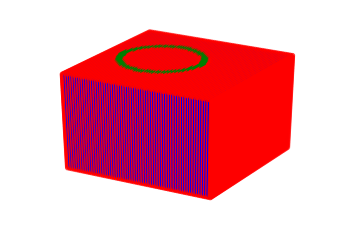

[0] -> Index: [0], Machining Feature: Chamfer
[1] -> Index: [0], Machining Feature: Chamfer
[2] -> Index: [0], Machining Feature: Chamfer
[3] -> Index: [0], Machining Feature: Chamfer
[4] -> Index: [0], Machining Feature: Chamfer
[5] -> Index: [0], Machining Feature: Chamfer
[6] -> Index: [0], Machining Feature: Chamfer
[7] -> Index: [0], Machining Feature: Chamfer
[8] -> Index: [0], Machining Feature: Chamfer
[9] -> Index: [0], Machining Feature: Chamfer
[10] -> Index: [0], Machining Feature: Chamfer
[11] -> Index: [0], Machining Feature: Chamfer
[12] -> Index: [0], Machining Feature: Chamfer
[13] -> Index: [0], Machining Feature: Chamfer
[14] -> Index: [0], Machining Feature: Chamfer
[15] -> Index: [0], Machining Feature: Chamfer
[16] -> Index: [0], Machining Feature: Chamfer
[17] -> Index: [0], Machining Feature: Chamfer
[18] -> Index: [0], Machining Feature: Chamfer
[19] -> Index: [0], Machining Feature: Chamfer
[20] -> Index: [0], Machining Feature: Chamfer
[21] -> Index: [0], Mac

In [22]:


def get_seg_samples(labels):

    samples = np.zeros((0, labels.shape[0], labels.shape[1], labels.shape[2]))

    for i in range(1, np.max(labels.astype(int)) + 1):
        idx = np.where(labels == i)

        if len(idx[0]) == 0:
            continue

        cursample = np.ones(labels.shape)
        cursample[idx] = 0
        cursample = np.expand_dims(cursample, axis=0)
        samples = np.append(samples, cursample, axis=0)

    return samples


def decomp_and_segment(sample):
   
    blobs = ~sample
    final_labels = np.zeros(blobs.shape)
    all_labels = measure.label(blobs)
    display_features(all_labels)  # Display connected component
    all_labels = np.array(all_labels)
    for i in range(1, np.max(all_labels) + 1):
        mk = (all_labels == i)
        distance = ndi.distance_transform_edt(mk)
        distance_arr = np.array(distance)
        labels = watershed(-distance_arr)

        max_val = np.max(final_labels) + 1
        idx = np.where(mk)

        final_labels[idx] += (labels[idx] + max_val)

    # display_features(final_labels) # Display watershed
    results = get_seg_samples(final_labels)

    return results


def get_bounding_box(voxel):
    a = np.where(voxel != 0)
    bbox = np.min(a[0]), np.max(a[0]), np.min(
        a[1]), np.max(a[1]), np.min(a[2]), np.max(a[2])
    return bbox




def zero_centering_norm(voxels):
    norm = (voxels - 0.5) * 2
    return norm


def load_voxel(file_path):
    hf = h5py.File(file_path, 'r')
    x = None

    for key in list(hf.keys()):
        with h5py.File('filename.h5', 'r') as f:
    # # Load the 'x' and 'y' datasets from the file
         x = np.array(f['group/x'], dtype=np.float32)
         y = np.array(f['group/y'], dtype=np.int8)

    return x


def display_voxel(voxels, color):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*np.indices(voxels.shape), c=color)
    plt.grid(b=None)
    plt.axis('off')
    plt.show()

def display_features(features):
    color_code = {0: "red", 1: "blue", 2: "green", 3: "orange",
                  4: "grey", 5: "yellow", 6: "pink", 7: "purple" ,8:"white"}
    unique, counts = np.unique(features, return_counts=True)
    colors = np.empty(features.shape, dtype=object)

    for i in range(len(unique)):
        colors[np.where(features == unique[i], True, False)] = color_code[i]

    colors = colors.flatten()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*np.indices(features.shape), c=colors)
    plt.grid(b=None)
    plt.axis('off')
    plt.show()






def display_machining_feature(index, count):
    feature_code = {0: "Chamfer", 1: "Through Hole", 2: "Triangular Passage", 3: "Rectangular Passage", 4: "6-Sided Passage",
                    5: "Triangular Through Slot", 6: "Rectangular Through Slot", 7: "Circular Through Slot",
                    8: "Rectangular Through Step", 9: "2-Sided Passage", 10: "Slanted Through Step",
                    11: "O-Ring", 12: "Blind Hole", 13: "Triangular Pocket",
                    14: "Rectangular Pocket", 15: "6-Sided Pocket", 16: "Circular End Pocket",
                    17: "Rectangular Blind Slot", 18: "Vertical Circular End Blind Slot", 19: "Horizontal Circular End Blind Slot",
                    20: "Triangular Blind Step", 21: "Circular Blind Step", 22: "Rectangular Blind Step", 23: "Round"}

    print(f"[{count}] -> Index: {index}, Machining Feature: {feature_code[index[0]]}")


if 1==1:
    # User Parameters
    num_classes = 24
    voxel_resolution = 64
    binvox_path = "/content/drive/MyDrive/3DCNN/0_22.binvox"
    checkpoint_path = "/content/checkpoint/featurenet_date_2023-02-20.ckpt"

    with open(binvox_path, 'rb') as f:
        model = read_as_3d_array(f)
    voxel = model.data
    #display_voxel(voxel, "grey") # Display voxel model

    features = decomp_and_segment(voxel)

    model = FeatureNet(num_classes=num_classes)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    model.load_weights(checkpoint_path)

    for i, feature in enumerate(features):
        input = zero_centering_norm(feature)
        x = tf.Variable(input, dtype=tf.float32)
        x = tf.reshape(x, [1, 1, voxel_resolution,
        
                    voxel_resolution, voxel_resolution])
        test_logits = model(x, training= False)
        y_pred = np.argmax(test_logits.numpy(), axis=1)
        display_machining_feature(y_pred, i)
        # display_voxel(feature, "grey")